In [33]:
 %matplotlib inline
from __future__ import division
import tensorflow as tf
import numpy as np
import h5py
import os
import six
import shutil
import tempfile
from six.moves import range
import itertools
import matplotlib.pyplot as plt
from moviepy.editor import ImageSequenceClip
import PIL
from tqdm import tqdm
from PIL import ImageOps
from PIL import ImageEnhance
import matplotlib.font_manager
from PIL import ImageDraw, ImageFont, ImageFilter

In [26]:
h5py.version.version

'2.7.0'

In [3]:
data_dir = '../../data'
crop_size = (64, 48)

h5 = h5py.File(os.path.join(data_dir, 'train.hdf5'),mode='r+')

In [4]:
print("{:10}| {:10}| {:30}".format("name", "dtype", "shape"))
print("-" * 40)
for name, dset in h5.items():
    print("{:10}| {:10}| {:30}".format(name, str(dset.dtype), str(dset.shape)))

name      | dtype     | shape                         
----------------------------------------
image     | uint8     | (10722, 60, 80)               
speed     | float32   | (10722, 1)                    
steering  | float32   | (10722, 1)                    
timestamp | float64   | (10722, 1)                    


In [5]:
def data_generator(batch_size=128, n_epoch=-1):
    n = len(h5['image'])
    idx = np.arange(n)
    np.random.shuffle(idx)
    n_batches = n // batch_size
    if n_epoch == -1:
        n_epoch = 1000000000
    for epoch in range(n_epoch):
        for b in range(0, n, batch_size):
            batch_idx = np.sort(idx[b:b+batch_size])
            yield {
                'image': h5['image'][batch_idx, :, :],
                'steering': h5['steering'][batch_idx, :],
                'speed': h5['speed'][batch_idx, :],
            }
    
batch = next(data_generator())

In [6]:
batch['image'].min(), batch['image'].max(), 

(15, 194)

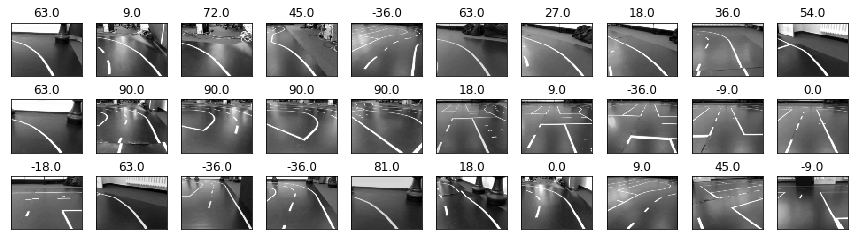

In [7]:
fig, axes = plt.subplots(3, 10, figsize=(15, 4))
for i, ax in enumerate(axes.flat):
    ax.set_title("{:.1f}".format(float(180 / np.pi * batch['steering'][i])))
    ax.imshow(batch['image'][i], cmap='gray')
    ax.grid('off')
    ax.set_xticks([])
    ax.set_yticks([])

#### number of seconds per epoch

In [8]:
#%%timeit -n 3

#for batch in data_generator(n_epoch=1):
#    pass

In [9]:
batch = next(data_generator())

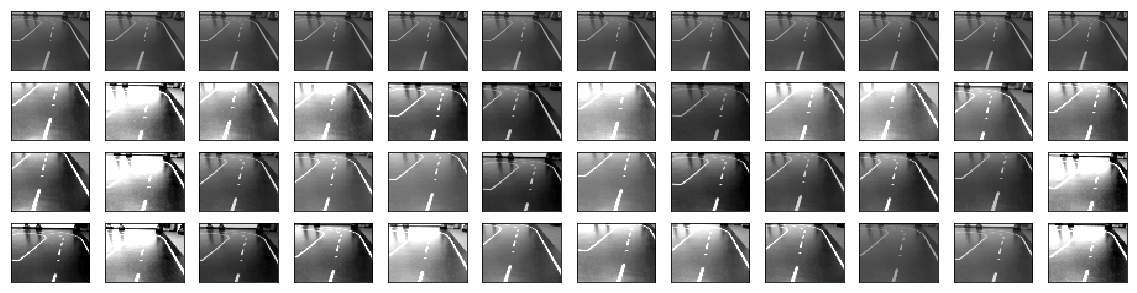

In [10]:
def augment_img(img):
    width, height = img.size
    max_crop_left = img.size[0] - crop_size[0]
    max_crop_upper = img.size[1] - crop_size[1]
    left = np.random.choice(max_crop_left)
    upper = np.random.choice(max_crop_upper)
    img = img.crop([left, upper, left + crop_size[0], upper + crop_size[1]])
                    #width - left, height - upper])
    brightness = ImageEnhance.Brightness(img)

    img = brightness.enhance(np.random.uniform(0.75, 2.5))
    contrast = ImageEnhance.Contrast(img)
    img = contrast.enhance(np.random.uniform(0.75, 2.5))
    return img

images = [PIL.Image.fromarray(x) for x in batch["image"]]
img = images[0]
fig, axes = plt.subplots(4, 12, figsize=(20, 5))

for ax in axes[:1].flat:
    ax.imshow(np.array(img), cmap='gray', vmin=0, vmax=255)
    ax.set_xticks([])
    ax.set_yticks([])
for ax in axes[1:].flat:
    ax.imshow(np.array(augment_img(img)), cmap='gray', vmin=0, vmax=255)
    ax.set_xticks([])
    ax.set_yticks([])

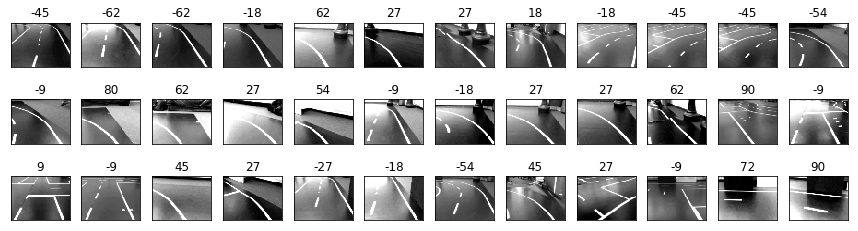

In [11]:
def augment_batch(batch):
    images = [PIL.Image.fromarray(x) for x in batch["image"]]
    images = [augment_img(img) for img in images]
    batch_aug = {'images': np.stack([np.array(img) for img in images])}
    for k, v in batch.items():
        if k != 'images':
            batch_aug[k] = v
    return batch_aug

batch_aug = augment_batch(batch)

fig, axes = plt.subplots(3, 12, figsize=(15, 4))

for ax, img, steering in zip(axes.flat, batch_aug['images'], batch_aug['steering']):
    ax.imshow((img), cmap='gray')
    ax.set_title("{:}".format(int(180*float(steering) / np.pi)))
    ax.set_xticks([])
    ax.set_yticks([])

In [12]:
def batch_to_numpy(batch):
    x = 2.* batch['images'] / 255. - 1 
    y = batch['steering']
    return x[:,:,:,np.newaxis],y

X, y = batch_to_numpy(batch_aug)
print("data: {}, labels: {}".format(X.shape, y.shape))
print("data max: {}, data min: {}".format(X.max(), X.min()))
print("labels max: {}, labels min: {}".format(y.max(), y.min()))

data: (128, 48, 64, 1), labels: (128, 1)
data max: 1.0, data min: -1.0
labels max: 1.5707963705062866, labels min: -1.5707963705062866


In [13]:
gpu_options = tf.GPUOptions(allow_growth=True)
 

sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

x = tf.placeholder(tf.float32, shape=[None, crop_size[1], crop_size[0], 1])
y_true = tf.placeholder(tf.float32, shape=[None, 1])

f = 12
k = 3


# data images are 48x64

l = tf.layers.conv2d(x,f, 5, padding='same')
l = tf.layers.batch_normalization(l)
l = tf.nn.relu(l)
l = tf.layers.max_pooling2d(l, 2, 2)

# 24x32 after pooling
l = tf.layers.conv2d(x,2*f, k, padding='same')
l = tf.layers.batch_normalization(l)
l = tf.nn.relu(l)
l = tf.layers.max_pooling2d(l, 2, 2)

# 12x16
l = tf.layers.conv2d(x,4*f, k, padding='same')
l = tf.layers.batch_normalization(l)
l = tf.nn.relu(l)
l = tf.layers.max_pooling2d(l, (2,2), 2)

# 6x8
l = tf.layers.conv2d(x,8*f, k, padding='same')
l = tf.layers.batch_normalization(l)
l = tf.nn.relu(l)
l = tf.layers.average_pooling2d(l,(6,8),1)
l = tf.contrib.layers.flatten(l)
y_pred = tf.tanh(tf.layers.dense(l,1)) * np.pi

opt = tf.train.AdamOptimizer(learning_rate=0.0003)
loss = tf.reduce_mean((y_pred - y_true)**2)
opt_op = opt.minimize(loss)

init_op = tf.global_variables_initializer()
sess.run(init_op)

history = []

In [15]:
for batch in tqdm(data_generator(n_epoch=7)):
    X,y = batch_to_numpy(augment_batch(batch))
    history.append(sess.run([loss, opt_op], feed_dict={x:X, y_true:y})[0])


13it [00:18,  1.30s/it]

KeyboardInterrupt: 

In [14]:
#saver = tf.train.Saver()
#save_path = saver.save(sess, "../nn_states/model.ckpt")
saver = tf.train.import_meta_graph('../nn_states/model.ckpt.meta')
saver.restore(sess,tf.train.latest_checkpoint('../nn_states/'))

INFO:tensorflow:Restoring parameters from ../nn_states/model.ckpt


In [15]:
result, = sess.run([y_pred], feed_dict={x:X})

In [16]:
#print(result[:])

(array([  1.,   0.,   4.,  15.,  29.,  42.,  20.,   9.,   6.,   2.]),
 array([-0.43002498, -0.3477906 , -0.26555621, -0.18332182, -0.10108744,
        -0.01885305,  0.06338133,  0.14561572,  0.2278501 ,  0.31008449,
         0.39231887]),
 <a list of 10 Patch objects>)

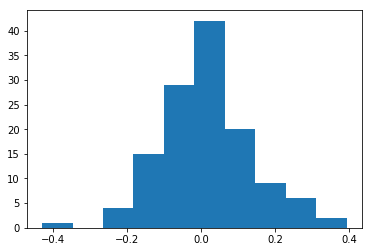

In [17]:
plt.hist(result.flatten())

(0, 1)

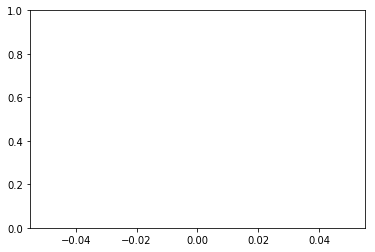

In [18]:
plt.plot(history)
plt.ylim(0,1)

In [19]:
#print(history)

In [20]:
def image_draw_info(img, steering_true, steering_pred, font=None):
    if font is None:
        fonts = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
        mono_fonts = [f for f in fonts if "mono" in f.lower() and 'bold' in f.lower()]
        mono_font = mono_fonts[0]
        font = ImageFont.truetype(mono_font, 18)

    draw = ImageDraw.Draw(img)

    draw.text((10, 20), "steering_true: {}".format(steering_true), fill="#00ff00", font=font)
    angle = steering_true + np.pi/2
    x = 1/2 * img.size[0]
    y = 100
    draw.line([x, y, x +  160*np.cos(angle), y  - 160*np.sin(angle)], fill="#00ff00", width=5)

    draw.text((400, 20), "steering_pred: {}".format(steering_pred), fill="#0000ff", font=font)
    angle = steering_pred + np.pi/2
    draw.line([x, y, x +  160*np.cos(angle), y  - 160*np.sin(angle)], fill="#0000ff", width=5)
    del draw



In [21]:
def extract_normalized_images_from(h5_data):
    x = 2.* h5_data['image'][:] / 255. - 1 
    y = h5_data['steering'][:]
    return x[:,6:-6,8:-8,np.newaxis],y

def get_chunks_from(h5_data, chunk_size):
    X,y = extract_normalized_images_from(h5_data)
    for i in range(0, len(X), chunk_size):
        yield X[i: i+chunk_size],y[i: i+chunk_size]
    
tmp = os.path.abspath('../tmp/')
h5_file = h5py.File(os.path.join(data_dir, 'test.hdf5'))
tmp_dir = tempfile.mkdtemp(dir=tmp)
predictions = []
for X,y in get_chunks_from(h5_file, 100):
    prediction = sess.run([y_pred], feed_dict={x:X, y_true:y})
    print(prediction)
    predictions.append(prediction[0])
predictions = np.concatenate(predictions)    


[array([[ 0.07458118],
       [ 0.0713454 ],
       [ 0.07965571],
       [ 0.08228886],
       [ 0.08228886],
       [ 0.08228886],
       [ 0.0822394 ],
       [ 0.0822394 ],
       [ 0.0822394 ],
       [ 0.0822394 ],
       [ 0.05287424],
       [ 0.04861045],
       [ 0.05287424],
       [ 0.05287424],
       [ 0.05287424],
       [ 0.04069984],
       [ 0.04399868],
       [ 0.04417688],
       [ 0.04630225],
       [ 0.04786336],
       [ 0.04525447],
       [ 0.04786336],
       [ 0.04934844],
       [ 0.04786336],
       [ 0.05109294],
       [ 0.05537607],
       [ 0.0540565 ],
       [ 0.05544103],
       [ 0.05812756],
       [ 0.05812756],
       [ 0.05812756],
       [ 0.05992209],
       [ 0.06769784],
       [ 0.07115696],
       [ 0.06769784],
       [ 0.07422079],
       [ 0.07422079],
       [ 0.07422079],
       [ 0.07764331],
       [ 0.07764331],
       [ 0.07874972],
       [ 0.07808158],
       [ 0.07902654],
       [ 0.07892521],
       [ 0.07902654],
       [ 

[array([[ 0.05709942],
       [ 0.07851031],
       [ 0.0779819 ],
       [ 0.06358083],
       [ 0.03803498],
       [ 0.03601088],
       [ 0.03436417],
       [ 0.02551937],
       [ 0.03394713],
       [ 0.04013047],
       [ 0.04018786],
       [ 0.05119021],
       [ 0.04352587],
       [ 0.04512318],
       [ 0.04546847],
       [ 0.04482349],
       [ 0.04037109],
       [ 0.03773969],
       [ 0.03533326],
       [ 0.03592041],
       [ 0.03431458],
       [ 0.0378083 ],
       [ 0.03614332],
       [ 0.05287863],
       [ 0.06318217],
       [ 0.06455072],
       [ 0.062402  ],
       [ 0.03699057],
       [ 0.03699057],
       [ 0.03699057],
       [ 0.03431611],
       [ 0.03676341],
       [ 0.03676341],
       [ 0.05414284],
       [ 0.05716722],
       [ 0.05711263],
       [ 0.05974363],
       [ 0.05974363],
       [ 0.05974363],
       [ 0.06720522],
       [ 0.06628563],
       [ 0.07305394],
       [ 0.07305394],
       [ 0.07165834],
       [ 0.07296722],
       [ 

[array([[ 0.05925411],
       [ 0.08926265],
       [ 0.09461364],
       [ 0.09533319],
       [ 0.09533319],
       [ 0.09533319],
       [ 0.09533319],
       [ 0.09470353],
       [ 0.09244754],
       [ 0.09470353],
       [ 0.09470353],
       [ 0.09470353],
       [ 0.09470353],
       [ 0.09470353],
       [ 0.09470353],
       [ 0.07977078],
       [ 0.07977078],
       [ 0.05846828],
       [ 0.05846828],
       [ 0.05846828],
       [ 0.05846828],
       [ 0.05846828],
       [ 0.05846828],
       [ 0.05846828],
       [ 0.05846828],
       [ 0.03623557],
       [ 0.03623557],
       [ 0.03623557],
       [ 0.03623557],
       [ 0.03623557],
       [ 0.03897417],
       [ 0.03929759],
       [ 0.03897417],
       [ 0.03897417],
       [ 0.03897417],
       [ 0.03897417],
       [ 0.04773316],
       [ 0.05210449],
       [ 0.05139665],
       [ 0.05452701],
       [ 0.05452701],
       [ 0.05452701],
       [ 0.06323714],
       [ 0.06323714],
       [ 0.06323714],
       [ 

[array([[ 0.09417705],
       [ 0.09417705],
       [ 0.08710875],
       [ 0.07988359],
       [ 0.0806337 ],
       [ 0.07306086],
       [ 0.07306086],
       [ 0.07306086],
       [ 0.07306086],
       [ 0.07306086],
       [ 0.07306086],
       [ 0.1109166 ],
       [ 0.07306086],
       [ 0.07306086],
       [ 0.07306086],
       [ 0.10310985],
       [ 0.09864613],
       [ 0.09864613],
       [ 0.09864613],
       [ 0.09864613],
       [ 0.10023884],
       [ 0.10023884],
       [ 0.10023884],
       [ 0.10023884],
       [ 0.10023884],
       [ 0.10023884],
       [ 0.10928164],
       [ 0.10879747],
       [ 0.10879747],
       [ 0.11046495],
       [ 0.11046495],
       [ 0.11046495],
       [ 0.10808884],
       [ 0.11390714],
       [ 0.11390714],
       [ 0.11059744],
       [ 0.11059744],
       [ 0.10939531],
       [ 0.11044525],
       [ 0.10581159],
       [ 0.08350494],
       [ 0.08080351],
       [ 0.07841625],
       [ 0.07186667],
       [ 0.06688077],
       [ 

[array([[ 0.08330703],
       [ 0.08027463],
       [ 0.08043648],
       [ 0.07902094],
       [ 0.07902094],
       [ 0.07902094],
       [ 0.08046094],
       [ 0.08156209],
       [ 0.08422231],
       [ 0.08473314],
       [ 0.08423718],
       [ 0.08473314],
       [ 0.07596539],
       [ 0.07400758],
       [ 0.07084856],
       [ 0.04987101],
       [ 0.05306048],
       [ 0.03507114],
       [ 0.03507114],
       [ 0.02910658],
       [ 0.02910658],
       [ 0.02482551],
       [ 0.0259168 ],
       [ 0.02202365],
       [ 0.02195287],
       [ 0.02314986],
       [ 0.0233729 ],
       [ 0.02847316],
       [ 0.03139865],
       [ 0.03139865],
       [ 0.03510702],
       [ 0.0326698 ],
       [ 0.0355196 ],
       [ 0.03718246],
       [ 0.03348809],
       [ 0.03183619],
       [ 0.03183619],
       [ 0.03435503],
       [ 0.03182605],
       [ 0.03182605],
       [ 0.04158444],
       [ 0.03182605],
       [ 0.04335044],
       [ 0.04335044],
       [ 0.04335044],
       [ 

[array([[ 0.03976421],
       [ 0.01976298],
       [ 0.01976298],
       [ 0.01264921],
       [ 0.01273743],
       [ 0.01294888],
       [ 0.01294888],
       [ 0.01294888],
       [ 0.01912348],
       [ 0.01294888],
       [ 0.030742  ],
       [ 0.03459457],
       [ 0.03941718],
       [ 0.03459457],
       [ 0.04960387],
       [ 0.05285617],
       [ 0.05285617],
       [ 0.05285617],
       [ 0.06604394],
       [ 0.09016501],
       [ 0.10077033],
       [ 0.11530238],
       [ 0.12133846],
       [ 0.11530238],
       [ 0.12575507],
       [ 0.12575507],
       [ 0.12575507],
       [ 0.11897276],
       [ 0.11411055],
       [ 0.10476416],
       [ 0.10476416],
       [ 0.09756056],
       [ 0.09312704],
       [ 0.09312704],
       [ 0.09415876],
       [ 0.09582525],
       [ 0.09350472],
       [ 0.09380464],
       [ 0.09116337],
       [ 0.09116337],
       [-0.00484932],
       [-0.00967577],
       [-0.00967577],
       [ 0.01399255],
       [ 0.03643848],
       [ 

[array([[ 0.05961656],
       [ 0.05548121],
       [ 0.05548121],
       [ 0.0327604 ],
       [ 0.0327604 ],
       [ 0.0327604 ],
       [ 0.02856927],
       [ 0.02856927],
       [ 0.02856927],
       [ 0.02856927],
       [ 0.02856927],
       [ 0.02856927],
       [ 0.02856927],
       [ 0.03343052],
       [ 0.03343052],
       [ 0.03343052],
       [ 0.03343052],
       [ 0.03343052],
       [ 0.04395055],
       [ 0.04395055],
       [ 0.04395055],
       [ 0.04762372],
       [ 0.04845387],
       [ 0.04845387],
       [ 0.04308831],
       [ 0.04308831],
       [ 0.04451784],
       [ 0.04308831],
       [ 0.04308831],
       [ 0.04308831],
       [ 0.04308831],
       [ 0.04308831],
       [ 0.0694554 ],
       [ 0.04308831],
       [ 0.04308831],
       [ 0.04308831],
       [ 0.04308831],
       [ 0.04308831],
       [ 0.04308831],
       [ 0.04308831],
       [ 0.04308831],
       [ 0.04308831],
       [ 0.04308831],
       [ 0.04308831],
       [ 0.04308831],
       [ 

[array([[ 0.07058949],
       [ 0.07133058],
       [ 0.0774254 ],
       [ 0.07712997],
       [ 0.0744557 ],
       [ 0.07920828],
       [ 0.07812851],
       [ 0.07812851],
       [ 0.07812851],
       [ 0.07812851],
       [ 0.07812851],
       [ 0.07812851],
       [ 0.07812851],
       [ 0.07116894],
       [ 0.07116894],
       [ 0.06912272],
       [ 0.06451992],
       [ 0.06378954],
       [ 0.06386361],
       [ 0.06301629],
       [ 0.06386361],
       [ 0.05980422],
       [ 0.05980422],
       [ 0.06277937],
       [ 0.06277937],
       [ 0.06277937],
       [ 0.07240963],
       [ 0.06961455],
       [ 0.06961455],
       [ 0.06961455],
       [ 0.07876021],
       [ 0.07876021],
       [ 0.07876021],
       [ 0.07876021],
       [ 0.07876021],
       [ 0.07876021],
       [ 0.0986639 ],
       [ 0.09845206],
       [ 0.09876639],
       [ 0.09876639],
       [ 0.09972539],
       [ 0.09972539],
       [ 0.10162703],
       [ 0.09736861],
       [ 0.09736861],
       [ 

[array([[ 0.09627427],
       [ 0.09201189],
       [ 0.09201189],
       [ 0.07984821],
       [ 0.07396922],
       [ 0.06927775],
       [ 0.04228401],
       [ 0.02610913],
       [ 0.04228401],
       [ 0.02082358],
       [ 0.01809127],
       [ 0.01637545],
       [ 0.01366289],
       [ 0.01657364],
       [ 0.01434752],
       [ 0.01434752],
       [ 0.01379633],
       [ 0.01589072],
       [ 0.01379633],
       [ 0.01313547],
       [ 0.01317654],
       [ 0.01317654],
       [ 0.01028665],
       [ 0.01232013],
       [ 0.00643679],
       [ 0.0066162 ],
       [ 0.0066162 ],
       [ 0.00444227],
       [ 0.00467582],
       [ 0.00071884],
       [ 0.00359712],
       [ 0.00199119],
       [ 0.00544123],
       [ 0.00504762],
       [ 0.00544123],
       [ 0.00549385],
       [ 0.00544123],
       [ 0.00797427],
       [ 0.00797427],
       [ 0.00840474],
       [ 0.00840474],
       [ 0.01827243],
       [ 0.01827243],
       [ 0.0186323 ],
       [ 0.0186323 ],
       [ 

In [34]:
def save_image(img, i):
    img_fname = os.path.join(tmp_dir, "{:06d}.png".format(i))
    img.save(img_fname)
    
try:
    for i,test_pred,test_real, img in zip(range(len(predictions)), predictions, h5_file['steering'][:], h5_file['image'][:]):
        img = PIL.Image.fromarray(img)
        img_scale = img.resize((640,480))
        img_scale = img_scale.convert("RGB")
        image_draw_info(img_scale, test_real, test_pred)
        save_image(img_scale,i)
        
    video = ImageSequenceClip(tmp_dir, fps=24, with_mask=False)
    video.write_videofile("test_set_evaluation.webm", ffmpeg_params=['-b:v', '0', '-crf', '20'])
finally:        
    shutil.rmtree(tmp_dir)


[MoviePy] >>>> Building video test_set_evaluation.webm
[MoviePy] Writing video test_set_evaluation.webm


100%|██████████| 3591/3591 [00:38<00:00, 94.02it/s] 

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_set_evaluation.webm 



In [ ]:
predictions[0].shape